In [1]:
# N.B. Activate .env ?
import numpy as np
import pandas as pd
#import pyarrow
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
#from transformers import BertTokenizer, BertModel, BertConfig
from transformers import RobertaTokenizer, RobertaModel, RobertaConfig
from prep_input_data import get_vectorized_labelled_data


In [12]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print("Using device: " + device)

Using device: cpu


In [13]:
import urllib
import os
# Corpus and dictionary files to use
corpus_file = '../../data/democracy_reports_corpus_annelisa_9_fixed.csv'

In [14]:
df_labelled = get_vectorized_labelled_data(corpus_file)
print(df_labelled.sample(1))

                                                sentence  country  year  \
63949  "Anti-restriction demonstrators often utilized...  estonia  2022   

                              source dimension1             dimension2  \
63949  freedomhouse_nations-transit"   freedoms  political competition   

      dimension3 dimension4  backsliding  \
63949          2        NaN          1.0   

                                   cat_4_sentence_nuance comments undefined0  \
63949  feels very biased in reporting + restrictions ...      NaN        NaN   

      undefined1  consensus                          label_vector  
63949        NaN        NaN  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]  


/Users/reggie/Workspace/backdem/democracy-text-classification/notebooks/prep_input_data.py:7: DtypeWarning: Columns (4,5,6,7,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(corpus_file, dtype={'year': str},comment='#')


In [15]:
# Get label names
labels = sorted(df_labelled['dimension1'].dropna().unique())
print(f'Labels: {labels}')

Labels: ['ambiguous', 'civil society', 'direct democracy', 'elections', 'electoral', 'equality', 'freedoms', 'liberal institutions', 'media', 'open government', 'participatory', 'political competition']


<Axes: ylabel='dimension1'>

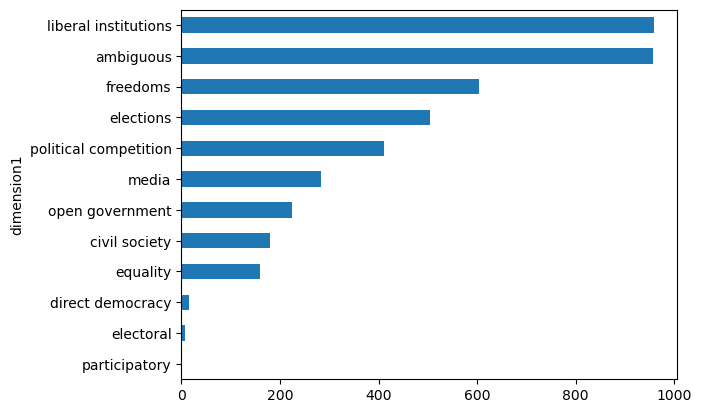

In [16]:
# Count the different classes to check how balanced they are
value_counts_dimension1 = df_labelled['dimension1'].value_counts()
value_counts_dimension1.sort_values().plot(kind="barh")

In [17]:
FRACTION_OF_DS_TO_USE = 1
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
EPOCHS = 10
LEARNING_RATE = 1e-05
NO_LABELS = len(labels)
MAX_LOSS = 0.05

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')


In [18]:
# Use part of the dataset
new_df = df_labelled.sample(frac=FRACTION_OF_DS_TO_USE, random_state=200)
# Display a sample of the dataset
new_df.sample(10)[['sentence', 'label_vector']]

,sentence,label_vector
456013,"council of the european union (2002), council ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
1067,"""Even when permits are issued, the government ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
455399,a comprehensive review of ireland’s anti-corru...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
8616,"""Private media ownership is concentrated, with...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
455849,this could lead to a revision of the mandate o...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
455595,ireland is currently in the process of transpo...,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
456664,"however, this safeguard does not apply to non-...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
415,"""The implementation of these policies thus far...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
333,"""A parliamentary inquiry into the collapse was...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
670,"""Media coverage during the 2019 election campa...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"


In [19]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe.sentence
        self.targets = self.data.label_vector
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())

        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [20]:
train_size = 0.8
train_dataset=new_df.sample(frac=train_size,random_state=200)
test_dataset=new_df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(new_df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (4305, 15)
TRAIN Dataset: (3444, 15)
TEST Dataset: (861, 15)


In [23]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [24]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class ROBERTAClass(torch.nn.Module):
    def __init__(self):
        super(ROBERTAClass, self).__init__()
        self.l1 = transformers.RobertaModel.from_pretrained('roberta-base')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, NO_LABELS)
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = ROBERTAClass()
model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROBERTAClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((

In [25]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [26]:
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [27]:
def train(epoch):
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if _%500==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        if loss.item() < MAX_LOSS:
            break
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss

In [28]:
# Train
for epoch in range(EPOCHS):
    loss = train(epoch)
    print(f'Epoch {epoch} done')
    if loss.item() < MAX_LOSS:
        print(f'Loss minimized to below {MAX_LOSS}')
        break

Epoch: 0, Loss:  0.7284325957298279
Epoch 0 done
Epoch: 1, Loss:  0.18634773790836334
Epoch 1 done
Epoch: 2, Loss:  0.12094911187887192
Epoch 2 done
Loss minimized to below 0.05


In [29]:
def validation():
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [30]:
# Validation
outputs, targets = validation()
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
# Check https://stephenallwright.com/micro-vs-macro-f1-score/

Accuracy Score = 0.6132404181184669
F1 Score (Micro) = 0.6826115061409178
F1 Score (Macro) = 0.5077073487556188


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [31]:
# Test our inputs
# Choose a sentence
#sample_row = new_df.sample()[['sentence', 'label_vector']]
sample_row = df_labelled.sample()[['sentence']]
sample_text = sample_row['sentence'].values[0]
print(sample_text)

"Various incentives have also been used to convince hundreds of local elected officials to form alliances with the SNS or change their party affiliation after elections.


In [32]:
def get_dimension_from_prediction(v, l=labels):    
    index = v.index(max(v))    
    return l[index]
    
# Encode the sentence
encoding = tokenizer.encode_plus(
  sample_text.lower(),
  add_special_tokens=True,
  max_length=MAX_LEN,
  padding='max_length',
  truncation=True,
  return_token_type_ids=True,
  return_tensors='pt'
)

input_ids = encoding["input_ids"]
mask = encoding["attention_mask"]
token_type_ids = encoding["token_type_ids"]
input_ids = input_ids.to(device, dtype=torch.long)
mask = mask.to(device, dtype=torch.long)
token_type_ids = token_type_ids.to(device, dtype=torch.long)

# Inference
output = torch.sigmoid(model(input_ids, mask, token_type_ids))
predictions = output[0].tolist()
for label, prediction in zip(labels, predictions):
    print(f"{label}: {prediction}")

ambiguous: 0.15183088183403015
civil society: 0.6749008893966675
direct democracy: 0.07963700592517853
elections: 0.021470114588737488
electoral: 0.016808753833174706
equality: 0.015162003226578236
freedoms: 0.016823289915919304
liberal institutions: 0.024906033650040627
media: 0.011466342024505138
open government: 0.0430937297642231
participatory: 0.014010093174874783
political competition: 0.010381071828305721


In [33]:
result_dim = get_dimension_from_prediction(predictions)
print(f'Statement "{sample_text}" was classified as: {result_dim}.')

Statement ""Various incentives have also been used to convince hundreds of local elected officials to form alliances with the SNS or change their party affiliation after elections." was classified as: civil society.


In [34]:
# Save model
torch.save(model, 'ROBERTA_classifier_democracy.pth')
torch.save(model.state_dict(), 'ROBERTA_classifier_democracy_state_dict.pth')